# Setup

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
import os

import sklearn.metrics
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

In [83]:
drive.mount("/content/drive", force_remount=True)
root = "/content/drive/My Drive/Horse Category Classification"
os.chdir(root)
data_root = root + "/data"
data_root_train = data_root + "/train"
data_root_test = data_root + "/test"

Mounted at /content/drive


In [84]:
os.chdir(root+ "/functions")
import modelling

In [85]:
BATCH_SIZE = 32
HEIGHT = 224
WIDTH = 224

# 03 Regularize

Now that I made sure that the model can actually perform the task, I want to make it more generic and improve validation / test set performance. I expect that obviously the performance of the training set will decrease due to less overfitting.


- Data Augmentation
- Shorter Training + Early Stopping

In custom models I will tryout Dropout and Batch Normalization as well.
Also I might generally add more data since my dataset is quite small.

In [86]:
class_names=['heavy', 'light', 'pony']

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_train,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    seed=42,
    subset="training"
)

Found 625 files belonging to 3 classes.
Using 500 files for training.


In [87]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_train,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(HEIGHT, WIDTH),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    crop_to_aspect_ratio=False
)

Found 625 files belonging to 3 classes.
Using 125 files for validation.


In [88]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_test,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(HEIGHT, WIDTH),
    shuffle=False,
)

Found 152 files belonging to 3 classes.


In [89]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [90]:
# data augmentation pipeline
data_augmentation = keras.Sequential(
  [
    layers.RandomZoom(0.1),
    # layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(HEIGHT,WIDTH,3)),
    # layers.experimental.preprocessing.RandomRotation(0.2)
  ]
)

In [91]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [92]:
mobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(HEIGHT,WIDTH,3))
model = modelling.recompile_model(mobileNet, 'rmsprop', 'categorical_crossentropy')

In [93]:
callbacks = EarlyStopping(monitor='val_loss', mode = "min", patience=8)

In [94]:
epochs=20
history = model.fit(
  train_ds,
  epochs=epochs,
  validation_data=val_ds,
  callbacks = callbacks
)

Epoch 1/20
16/16 [==============================] - 9s 251ms/step - loss: 3.3907 - accuracy: 0.4440 - val_loss: 0.8611 - val_accuracy: 0.5840
Epoch 2/20
16/16 [==============================] - 3s 167ms/step - loss: 1.2488 - accuracy: 0.5000 - val_loss: 0.9696 - val_accuracy: 0.5120
Epoch 3/20
16/16 [==============================] - 3s 160ms/step - loss: 1.0298 - accuracy: 0.5660 - val_loss: 1.0076 - val_accuracy: 0.5280
Epoch 4/20
16/16 [==============================] - 3s 176ms/step - loss: 0.8764 - accuracy: 0.5960 - val_loss: 1.1449 - val_accuracy: 0.4960
Epoch 5/20
16/16 [==============================] - 3s 162ms/step - loss: 0.8387 - accuracy: 0.6200 - val_loss: 1.0958 - val_accuracy: 0.5840
Epoch 6/20
16/16 [==============================] - 3s 158ms/step - loss: 0.7630 - accuracy: 0.6700 - val_loss: 1.0020 - val_accuracy: 0.5360
Epoch 7/20
16/16 [==============================] - 3s 158ms/step - loss: 0.8500 - accuracy: 0.6620 - val_loss: 0.9614 - val_accuracy: 0.5600
Epoch 

In [95]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

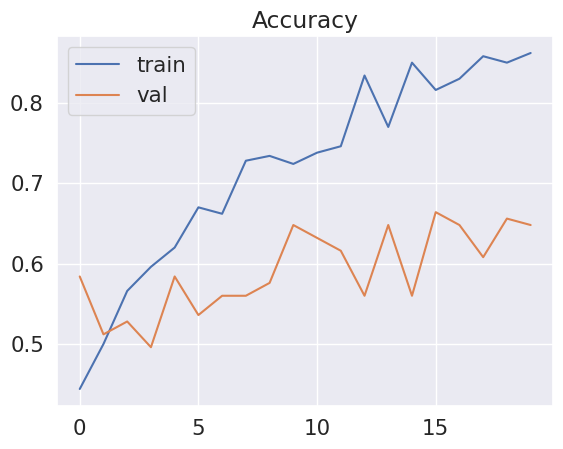

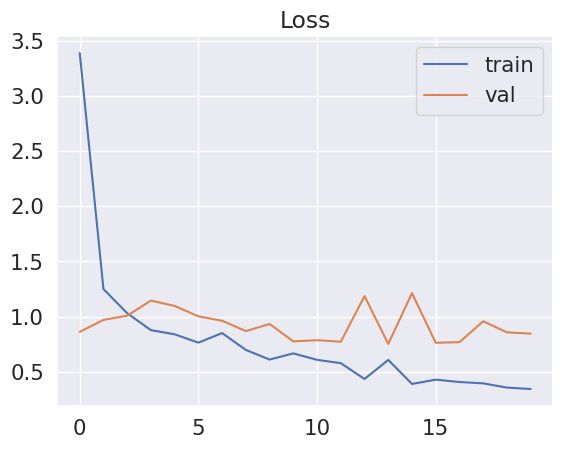

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

In [97]:
trainset_predictions = model.predict(train_ds)
train_predicted_labels = [prediction.argmax() for prediction in trainset_predictions]
train_true_labels = modelling.extract_labels_categorical(train_ds)

16/16 [==============================] - 3s 181ms/step


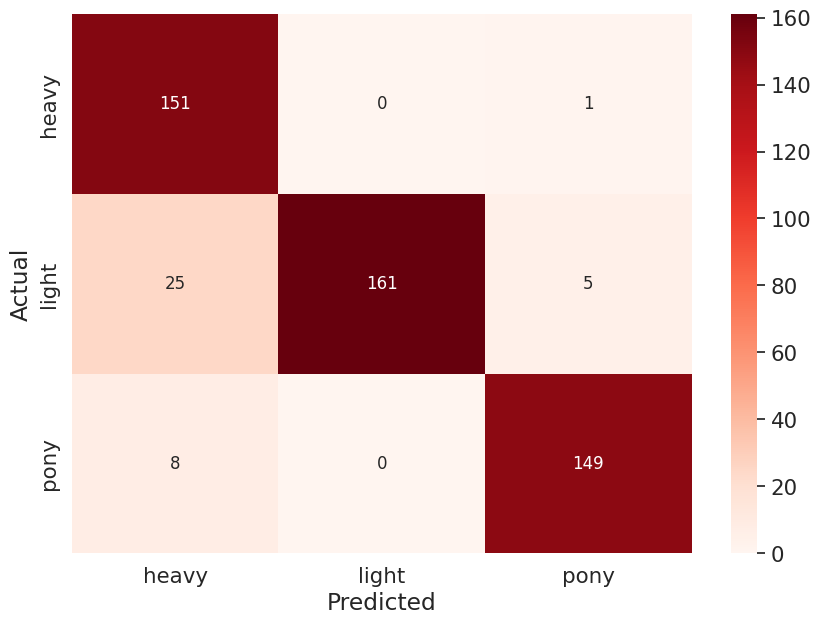

In [98]:
confusion_matrix_train = np.array(tf.math.confusion_matrix(train_true_labels, train_predicted_labels))
confusion_matrix_train = tf.math.confusion_matrix(train_true_labels, train_predicted_labels)
modelling.plot_cm(confusion_matrix_train, class_names)

In [99]:
import pandas as pd
report = pd.DataFrame(columns=['dataset','precision','recall','f1'])

In [100]:
training_report = classification_report(train_true_labels,train_predicted_labels, output_dict=True)
training = {'dataset':'training', 'precision': training_report['weighted avg']['precision'], 'recall': training_report['weighted avg']['recall'], 'f1':training_report['weighted avg']['f1-score']}

In [101]:
valset_predictions = model.predict(val_ds)
val_predicted_labels = [prediction.argmax() for prediction in valset_predictions]
val_true_labels = modelling.extract_labels_categorical(val_ds)

4/4 [==============================] - 0s 47ms/step


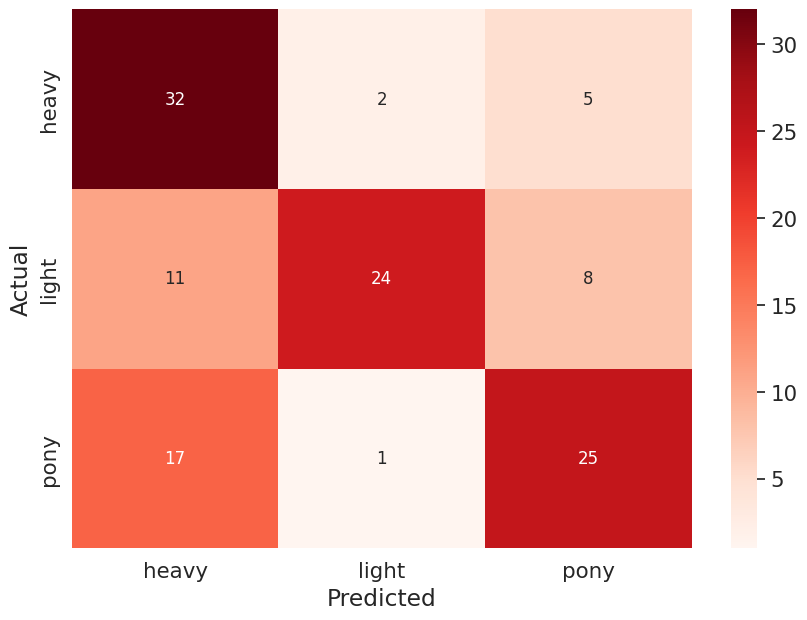

In [102]:
confusion_matrix_val = np.array(tf.math.confusion_matrix(val_true_labels, val_predicted_labels))
confusion_matrix_val = tf.math.confusion_matrix(val_true_labels, val_predicted_labels)
modelling.plot_cm(confusion_matrix_val, class_names)

In [103]:
val_report = classification_report(val_true_labels,val_predicted_labels, output_dict=True)
validation = {'dataset':'validation', 'precision': val_report['weighted avg']['precision'], 'recall': val_report['weighted avg']['recall'], 'f1':val_report['weighted avg']['f1-score']}

In [104]:
testset_predictions = model.predict(test_ds)
test_predicted_labels = [prediction.argmax() for prediction in testset_predictions]
test_true_labels = modelling.extract_labels_categorical(test_ds)

5/5 [==============================] - 0s 90ms/step


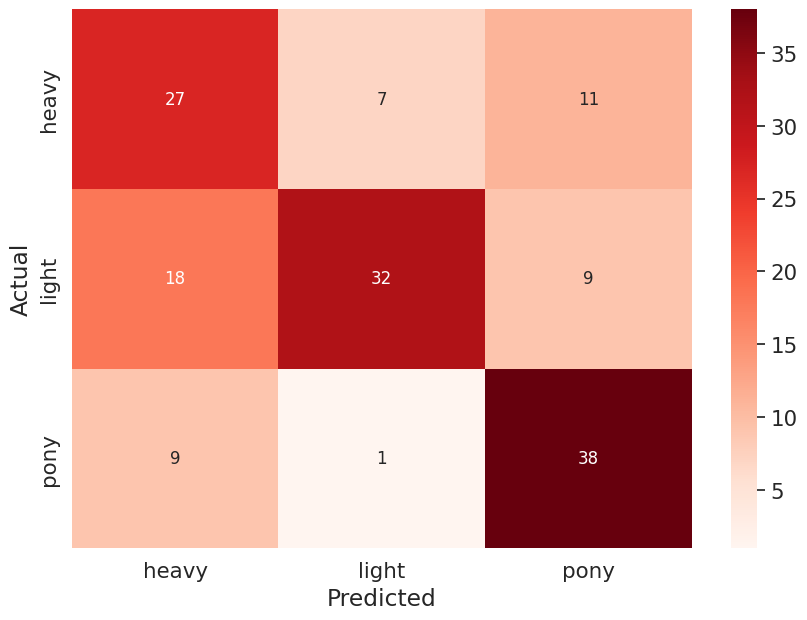

In [105]:
confusion_matrix_test = np.array(tf.math.confusion_matrix(test_true_labels, test_predicted_labels))
confusion_matrix_test = tf.math.confusion_matrix(test_true_labels, test_predicted_labels)
modelling.plot_cm(confusion_matrix_test, class_names)

In [106]:
test_report = classification_report(test_true_labels,test_predicted_labels, output_dict=True)
test = {'dataset':'test', 'precision': test_report['weighted avg']['precision'], 'recall': test_report['weighted avg']['recall'], 'f1':test_report['weighted avg']['f1-score']}

In [107]:
report = report.append(training, ignore_index=True)
report = report.append(validation, ignore_index=True)
report = report.append(test, ignore_index=True)

<ipython-input-107-29a94b9ba1ff>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report = report.append(training, ignore_index=True)
<ipython-input-107-29a94b9ba1ff>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report = report.append(validation, ignore_index=True)
<ipython-input-107-29a94b9ba1ff>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report = report.append(test, ignore_index=True)


# Summary

In general, the few regularization steps already work! The performance of the training dataset decreased as overfitting was reduced. Meanwhile the validation and testset performance rose significantly. This experiment was sucessful, even though I could do much more here. In a next step I want to look at different models and fine tune each of them suiting their needs with the general approach of this built pipeline.

In [108]:
report.head(3)

,dataset,precision,recall,f1
0,training,0.933323,0.922000,0.922592
1,validation,0.698494,0.648000,0.649928
2,test,0.665449,0.638158,0.638829
